In [309]:
import os
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import logging
import time
import xgboost as xgb

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold

warnings.filterwarnings('ignore')

In [310]:
df = pd.read_csv('covid_clean_lags.csv')
df = df.rename(columns={'date': 'ds', 'new_cases': 'y'})
df['ds'] = pd.to_datetime(df['ds'])

In [311]:
train_percentage = 0.8

# Function to split each group into train and test sets
def group_train_test_split(group):
    train, test = train_test_split(group, train_size=train_percentage, shuffle=False)
    return train, test

# Apply the function to each country group
train_set, test_set = zip(*df.groupby('location', group_keys=False).apply(group_train_test_split))

# Concatenate the results back into dataframes
train = pd.concat(train_set)
test = pd.concat(test_set)

In [312]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['ds'].dt.hour
    df['dayofweek'] = df['ds'].dt.dayofweek
    df['quarter'] = df['ds'].dt.quarter
    df['month'] = df['ds'].dt.month
    df['year'] = df['ds'].dt.year
    df['dayofyear'] = df['ds'].dt.dayofyear
    df['dayofmonth'] = df['ds'].dt.day
    df['weekofyear'] = df['ds'].dt.isocalendar().week.astype(np.int64)
    return df

In [313]:
train = create_features(train)
test = create_features(test)


y_train = train['y']
X_train = train.copy()
X_train.drop(columns=['y', 'ds', 'tests_units'], inplace=True)
X_train = pd.get_dummies(X_train, columns=['iso_code', 'continent', 'location'])

y_test = test['y']
X_test = test.copy()
X_test.drop(columns=['y', 'ds', 'tests_units'], inplace=True)
X_test = pd.get_dummies(X_test, columns=['iso_code', 'continent', 'location'])

In [314]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

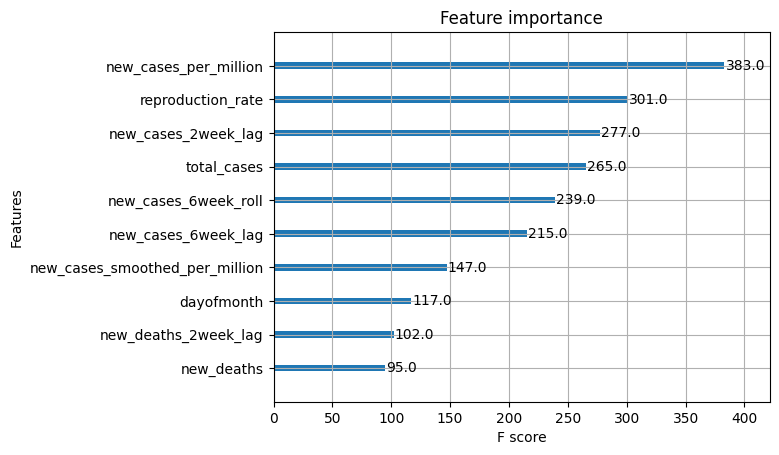

In [315]:
xgb.plot_importance(reg, max_num_features=10)

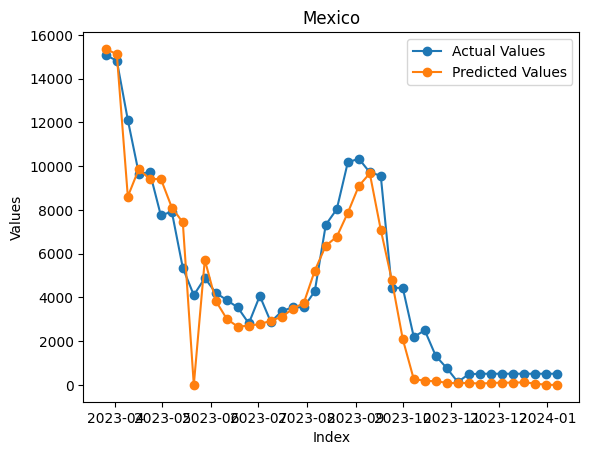

Mexico


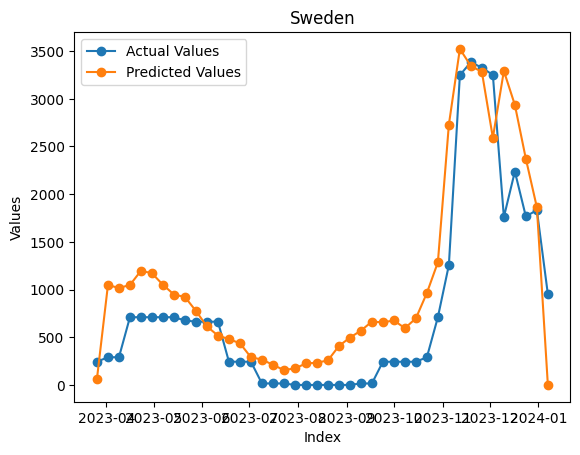

Sweden


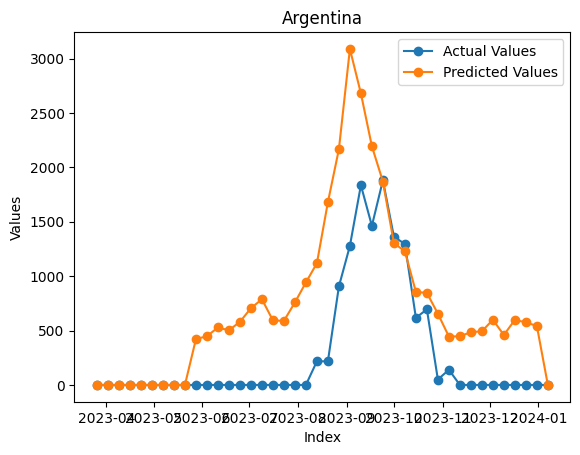

Argentina


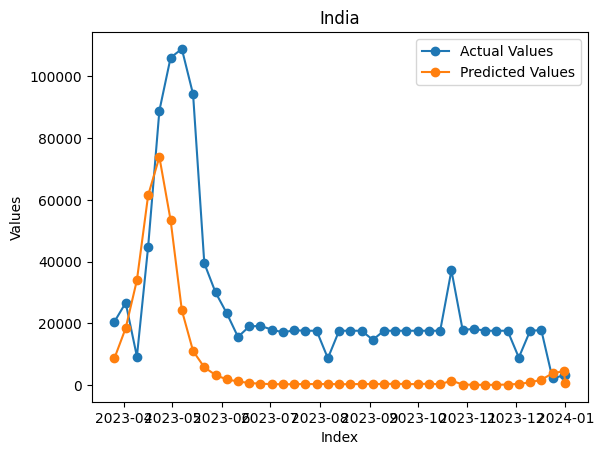

India


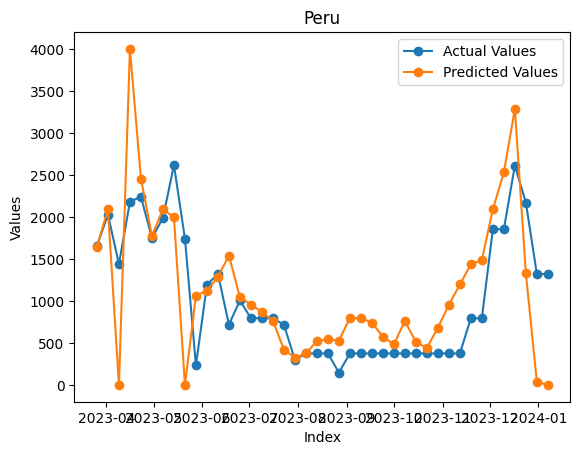

Peru


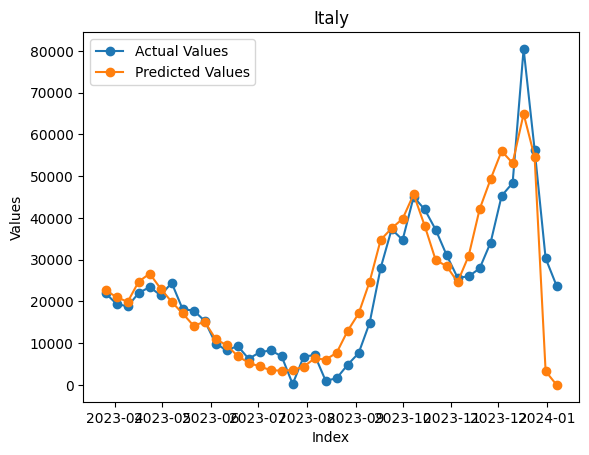

Italy


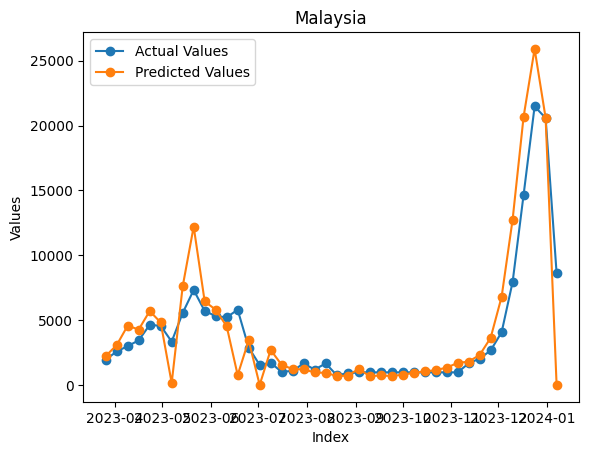

Malaysia


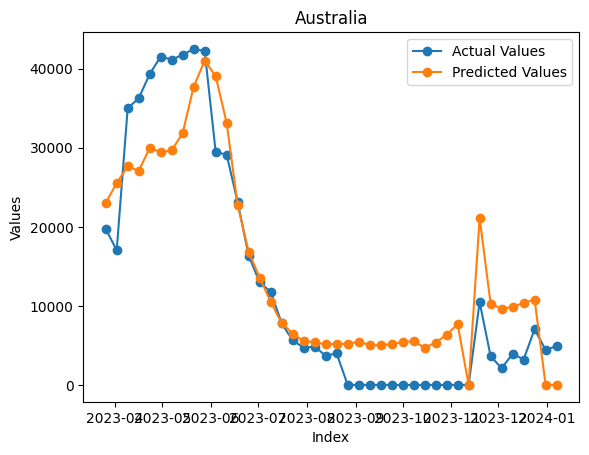

Australia


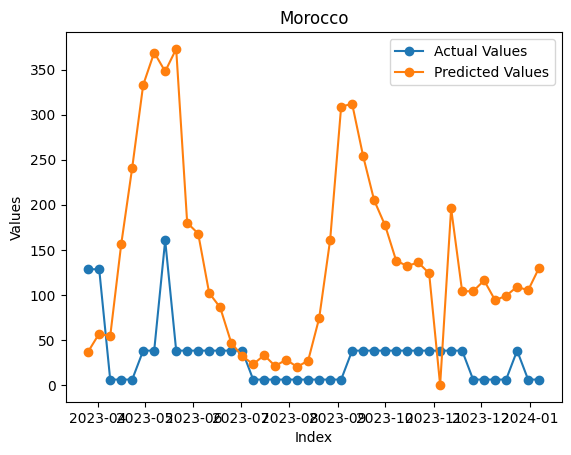

Morocco


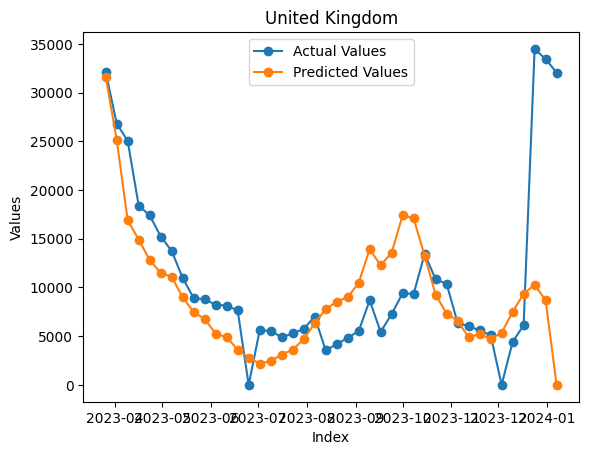

United Kingdom


In [316]:
path = 'country_data/univariate/'

files = os.listdir(path)

locations = []
rmses = []
mases = []
maes = []

for file_name in files[:]:
    if os.path.isfile(os.path.join(path, file_name)) and file_name != '.dockerenv':
        location = file_name.split('_')[0]
        location_df = df[df['location'] == location]
        train_size = int(len(location_df) * 0.8)
        train, test = location_df.iloc[:train_size], location_df.iloc[train_size:]

        y_test1 = location_df['y'][train_size:]

        X_test1 = X_test[X_test['location_' + location] == True]

        predictions = reg.predict(X_test1)
        predictions = np.maximum(predictions, 0)

        plt.plot(location_df.iloc[train_size:]['ds'], predictions, label='Actual Values', marker='o')
        plt.plot(location_df.iloc[train_size:]['ds'], y_test1, label='Predicted Values', marker='o')
        plt.xlabel('Index')
        plt.ylabel('Values')
        plt.title(location)
        plt.legend()
        plt.show()

        mae = mean_absolute_error(y_test1, predictions)
        rmse = np.sqrt(mean_squared_error(y_test1, predictions))
        mase = mae / np.mean(np.abs(np.diff(y_test1)))

        locations.append(location)
        rmses.append(rmse)
        mases.append(mase)
        maes.append(mae)
        print(location)


results = pd.DataFrame({
    'location': locations,
    'rmse': rmses,
    'mase': mases,
    'mae': maes
})
                



In [318]:
results

,location,rmse,mase,mae
0,Mexico,1338.784233,0.886940,941.952126
1,Sweden,529.788115,1.581918,413.073590
2,Argentina,624.370266,2.638945,464.325632
3,India,26403.211242,5.607250,20602.540638
4,Peru,661.164187,0.876672,459.782269
5,Italy,8062.767517,1.063786,5434.001015
6,Malaysia,2376.943060,0.584544,1372.424104
7,Australia,6027.441358,1.804699,5003.594773
8,Morocco,146.989841,2.737056,116.758796
9,United Kingdom,8180.007451,2.608055,4913.384859


In [319]:
results.to_csv('xgboost_alex_o.csv', index=False)